In [10]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.8. Manuscript Statistics')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1009. NC ENVRIOSCAN/P1009.3. Analyses/P1009.3.8. Manuscript Statistics/Output')
cur_date = "033023"

library(readxl)
library(tidyverse)
library(reshape2)
library(tidytext)
library(rcartocolor)
library(MetBrewer)
library(cowplot)
library(scales)

# reading in files
housing_df = data.frame(read_excel("Input/Imputed_Housing_Data_030923.xlsx"))
whp_df = data.frame(read_excel("Input/Imputed_Wildfire_Hazard_030923.xlsx"))
local_moran_df = data.frame(read_excel("Input/Local_Moran_WHP_033023.xlsx"))
ejscreen_cluster_df = data.frame(read_excel("Input/GEO_ID_Sociodemographic_Clusters_030123.xlsx"))

In [11]:
head(housing_df)
head(whp_df)
head(local_moran_df)
head(ejscreen_cluster_df)

,GEO_ID,Census_Tract,County,Total_Housing_Units,Housing_Density,Total_Occupied_Housing_Units,Total_Owner_Occupied_Housing_Units,Median_Year_Structure_Built,Owner_Occupied_Housing_Units_Less_than_HPI,Median_House_Value,Median_Gross_Rent,Median_Gross_Rent_Percentage_of_Household_Income
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14000US37001020100,201.00,Alamance,2006,31.54848,1757,851,1949,824,149600,614,27.9
2,14000US37001020200,202.00,Alamance,1943,26.03618,1675,881,1961,881,83400,609,31.5
3,14000US37001020300,203.00,Alamance,3254,71.60011,2930,2015,1971,1980,91500,763,37.7
4,14000US37001020400,204.00,Alamance,2590,53.47674,2327,1510,1974,1487,96900,659,34.3
5,14000US37001020501,205.01,Alamance,1435,122.03583,1280,990,1973,932,137400,584,46.7
6,14000US37001020502,205.02,Alamance,1484,471.34609,1275,666,1980,666,73500,672,35.9


,GEO_ID,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,14000US37141920201,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%
2,14000US37141920401,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%
3,14000US37141920402,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%
4,14000US37141920403,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%
5,14000US37141920601,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%
6,14000US37141990100,37141990100,Pender,9901.00,596842.6,715.5177,5,0-20%


,GEO_ID,Local_Moran_Statistic,P.Value,P.Adj,Quadrant
,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,14000US37141920201,11.356081,9.952669e-11,2.912814e-09,High-High
2,14000US37141920401,17.340772,7.750734e-16,5.735517e-14,High-High
3,14000US37141920402,14.008272,7.502267e-11,2.225335e-09,High-High
4,14000US37141920403,14.042942,1.277182e-15,9.043270e-14,High-High
5,14000US37141920601,12.780639,3.378197e-13,1.425989e-11,High-High
6,14000US37141990100,8.901817,3.958719e-07,7.490852e-06,High-High


,GEO_ID,Census_Tract,County,Variables,Value,Scaled_Value,Cluster
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,14000US37001020100,201,Alamance,Population_Under_5,9.5,1.45508797,3
2,14000US37001020100,201,Alamance,Population_Over_65,15.1,-0.20849618,3
3,14000US37001020100,201,Alamance,Race_Non_White,39.0,0.33121718,3
4,14000US37001020100,201,Alamance,Hispanic_Latino,9.5,0.04837140,3
5,14000US37001020100,201,Alamance,Non_Proficient_English_Speakers,3.9,-0.09907552,3
6,14000US37001020100,201,Alamance,Poverty_Overall,27.2,1.07521173,3


Defining a GEO id to be have an elevated risk of WHP if the data point falls within the 95th percentile. Based on this [ref](https://www.fs.usda.gov/rm/pubs/rmrs_p073/rmrs_p073_060_076.pdf).

In [4]:
high_risk_WHP = quantile(whp_df$Wildfire_Hazard_Potential_Mean, 0.95)[[1]]
high_risk_WHP

[1] 438.9983

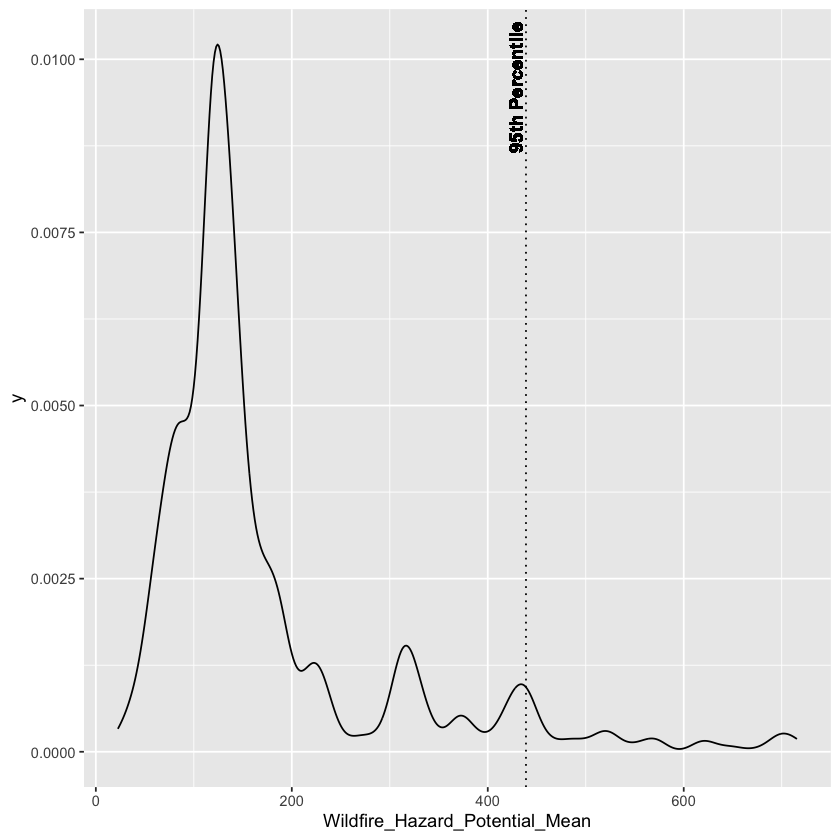

In [5]:
ggplot(whp_df) + 
  geom_density(aes(Wildfire_Hazard_Potential_Mean)) + 
  geom_vline(xintercept = high_risk_WHP, linetype = "dotted") + 
  geom_text(aes(x = high_risk_WHP - 10, label = "95th Percentile", y = 0.0096), angle = 90, fontface = "bold")

In [23]:
# creating 1 df
# ejscreen_cluster_moran_df = inner_join(ejscreen_cluster_df[,c(1,7)], local_moran_df[,c(1,4)])
# whp_housing_df = inner_join(whp_df, housing_df)

full_df = reduce(list(local_moran_df[,c(1,4)], whp_df, housing_df, unique(ejscreen_cluster_df[,c(1,7)])), 
                 inner_join)
head(full_df)

dim(full_df)

Joining, by = "GEO_ID"
Joining, by = c("GEO_ID", "County", "Census_Tract")
Joining, by = "GEO_ID"


,GEO_ID,P.Adj,FIPS,County,Census_Tract,Avg_ACRES,Wildfire_Hazard_Potential_Mean,Wildfire_Hazard_Potential_Quintile_Number,Wildfire_Hazard_Potential_Quintile_Percentage,Total_Housing_Units,Housing_Density,Total_Occupied_Housing_Units,Total_Owner_Occupied_Housing_Units,Median_Year_Structure_Built,Owner_Occupied_Housing_Units_Less_than_HPI,Median_House_Value,Median_Gross_Rent,Median_Gross_Rent_Percentage_of_Household_Income,Cluster
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14000US37141920201,2.912814e-09,37141920201,Pender,9202.01,596842.6,715.5177,5,0-20%,2385,961.7430,1773,1541,1996,1230,202400,821,17.6,1
2,14000US37141920401,5.735517e-14,37141920401,Pender,9204.01,596842.6,715.5177,5,0-20%,955,175.7199,752,566,1976,531,106100,712,24.5,3
3,14000US37141920402,2.225335e-09,37141920402,Pender,9204.02,596842.6,715.5177,5,0-20%,1069,821.6787,1011,694,1980,677,104300,708,34.3,1
4,14000US37141920403,9.043270e-14,37141920403,Pender,9204.03,596842.6,715.5177,5,0-20%,1505,891.3438,1366,1101,1989,930,152800,801,50.0,1
5,14000US37141920601,1.425989e-11,37141920601,Pender,9206.01,596842.6,715.5177,5,0-20%,1226,875.4509,1171,1102,1990,991,93700,518,50.0,2
6,14000US37153970400,7.341589e-16,37153970400,Richmond,9704.00,307147.7,704.1077,5,0-20%,1784,662.7341,1512,1278,1972,1221,89900,517,45.3,1


[1] 2156   19

In [25]:
# filtering for geo ids that have a high risk WHP & are significantly correlated to its neighbors
high_risk_df = full_df %>%
    filter(Wildfire_Hazard_Potential_Mean > high_risk_WHP & P.Adj < 0.05)

dim(high_risk_df)

[1] 100  19

In [26]:
# determinig the number of housing units in high risk GEO ids
high_risk_df %>%
    summarize(Total_high_risk_Housing_Units = sum(Total_Housing_Units))

Total_high_risk_Housing_Units
<dbl>
205646


In [27]:
# determinig the value of all the housing units in high risk GEO ids
high_risk_df %>%
    mutate(Total_Housing_Value_of_GEO_id = Total_Housing_Units * Median_House_Value) %>%
    summarize(Total_NC_high_risk_Housing_Value = dollar(sum(Total_Housing_Value_of_GEO_id)))

Total_NC_high_risk_Housing_Value
<chr>
"$30,599,076,993"


In [30]:
# filtering for geo ids that have a high risk WHP, are significantly correlated to its neighbors 
# and call within a more vulnerable ejscreen cluster (either 2 or 3)
high_risk_ejscreen_df = full_df %>%
    filter(Wildfire_Hazard_Potential_Mean > high_risk_WHP & P.Adj < 0.05 & Cluster != 1)

dim(high_risk_ejscreen_df)

# determinig the number of housing units in high risk GEO ids
high_risk_ejscreen_df %>%
    summarize(Total_high_risk_Housing_Units = sum(Total_Housing_Units))

# determinig the value of all the housing units in high risk GEO ids
high_risk_ejscreen_df %>%
    mutate(Total_Housing_Value_of_GEO_id = Total_Housing_Units * Median_House_Value) %>%
    summarize(Total_NC_high_risk_Housing_Value = dollar(sum(Total_Housing_Value_of_GEO_id)))

[1] 48 19

Total_high_risk_Housing_Units
<dbl>
96922


Total_NC_high_risk_Housing_Value
<chr>
"$10,161,805,900"


- Over **200,000 homes**, worth **\$30.6B**, are located in 100 census tracts with elevated risk to future wildfire events. 

- Out of these 100 census tracts, 48 are considered to be more socioeconomically vulnerable. In addition, almost **half of the 200,000 homes with elevated wildfire risk are in socioeconomically vulnerable census tracts**, but are only **worth about a third of the total value of the high risk properties or \$10.2B**. 

- This is based on the 2,156 GEO ids that were present in each of the datasets. 